# 0.1 Implementing the Combinatorial Generalization Task

Designing the combinatorial task that will be used for the 0.0 release. See the [readme](combinatorics.rst) for more detail on the task.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,pandas,matplotlib,seaborn

Thu Feb 14 2019 01:15:10 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
pandas 0.24.1
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 016fe750436621c5f43133787c21d99b9dca7903
Git branch : task


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [4]:
# Standard library imports
import logging

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [5]:
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging

## Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [6]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [8]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## Visualizing the Task

The heart of the task is creating a mapping from a $n$x$n$ boolean matrix to a $n$x$2$ boolean matrix. Below is an example of what the resulting $n$x$2$ matrix should look like.


In [71]:
example_y = np.random.choice(2, (5,2), True)
print(example_y)

[[0 1]
 [1 0]
 [1 1]
 [0 0]
 [1 1]]


Visualizing this using a heatmap will probably be an easier way to make sense of it.

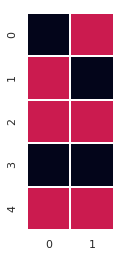

In [72]:
sns.heatmap(example_y, vmin=0, vmax=2, cbar=False, linewidths=1, square=True)
plt.show()

Let's turn this setup into a function, with the specific defaults to produce the above plot.

In [73]:
def heatmap(data, vmin=0, vmax=2, cbar=False, linewidths=1, square=True, 
            *args, **kwargs):
    """Wrapper function of `sns.heatmap` with some different defaults. 
    
    Only changed values are shown, see the documentation for `sns.heatmap`
    for all available parameters.
        
    Parameters
    ----------
    vmin : float, optional
        Min color. Now set to 0
        
    vmax : float, optional
        Max color. Now set to 2
        
    cbar : bool, optional
        Color bar present or not. Now set to False
        
    linewidths : float, optional
        Width of lines between boxes. Now set to 1
        
    square : bool, optional
        Maintain aspect ratio. Now set to True
    """
    sns.heatmap(data, vmin=vmin, vmax=vmax, cbar=cbar,
                linewidths=linewidths, square=square, *args, **kwargs)

And sanity checking things:

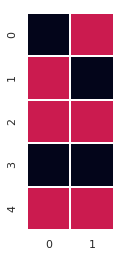

In [75]:
heatmap(example_y)
plt.show()

Moving on to the inputs that wouild generate this, putting it together by hand it would look like this: 

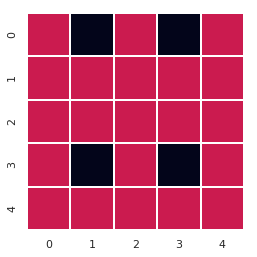

In [77]:
example_x = np.array([[1, 0, 1, 0, 1],
                      [1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1],
                      [1, 0, 1, 0, 1],
                      [1, 1, 1, 1, 1]])
heatmap(example_x)

## Inverse Transform

So let's try to put together a straight forward implementation of the mapping from `y` to `x` so we can start generating data.

In [138]:
def inverse_transform_first_pass(y):
    """Turns the inputted nxn array into the nx2 array
    
    Parameters
    ----------
    y : array-like (nx2)
        The the label we are transforming.
        
    Returns
    -------
    x : np.array (nxn)
        The `x` that would have generated the inputted `y`.
    """
    # Grab the length of y
    n = len(y)
    # Create a horizontal array and a vertical array according to y
    horizontal, vertical = np.tile(y, n).reshape(n, n, 2).T
    return (horizontal.T + vertical).astype(bool)

generated_x = inverse_transform_first_pass(example_y)
# Quick check of the function
assert np.array_equal(generated_x, example_x)

And in case we aren't convinved, here is a plot of `y`, the expected `x` and the generated `x`:

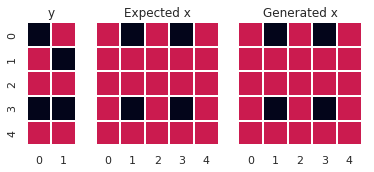

In [160]:
# Create 3 subplots with the same y, and set the width ratios
_, axn = plt.subplots(1, 3, sharey=True, 
                      gridspec_kw={'width_ratios': [2, 5, 5]})
# Create a list of the titles for each
titles = ['y', 'Expected x', 'Generated x']
# Create a list of values we will pass into the heatmap
values = [example_y, example_x, generated_x]

# Loop through and generate the plots
for i, ax in enumerate(axn):
    heatmap(values[i], ax=ax)
    ax.set_title(titles[i])
plt.show()

Now that we're satisfied, let's revisit the line that generates the `y` values:
```
example_y = np.random.choice(2, (5,2), True)
```

This generates a single `y` which will be fed into `inverse_transform_first_pass` to generate a single `x`. Let's ensure the function above can take in an array of `y`s of arbitrary length - call it capital `Y`, and output all the `x`s, or just capital `X`.

In [302]:
# Number of samples to generate, starting off real simple
N = 3
# Input Y data
example_Y = np.random.choice(2, (N,5,2), True)
# Let's see if it even runs
inverse_transform_first_pass(example_Y)

ValueError: cannot reshape array of size 90 into shape (3,3,2)

Of course not, we're making too may assumptions about the shape. We probably can't visualize it either.

In [164]:
heatmap(example_Y)

ValueError: Must pass 2-d input

Alright, let's fix the visualization first.

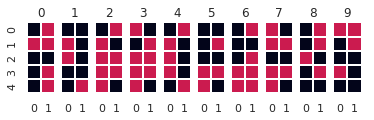

In [262]:
# General warning, this will overwrite the originally defined heatmap
def heatmap(data, vmin=0, vmax=2, cbar=False, linewidths=1, square=True, 
            samples_per_row=10, *args, **kwargs):
    """Wrapper function of `sns.heatmap` with some different defaults. 
    
    Only changed values are shown, see the documentation for `sns.heatmap`
    for all available parameters.
        
    Parameters
    ----------
    vmin : float, optional
        Min color. Now set to 0
        
    vmax : float, optional
        Max color. Now set to 2
        
    cbar : bool, optional
        Color bar present or not. Now set to False
        
    linewidths : float, optional
        Width of lines between boxes. Now set to 1
        
    square : bool, optional
        Maintain aspect ratio. Now set to True
        
    samples_per_row : int, optional
        Number of samples to have in a plotting row before creating a 
        new row
    """
    # Force the data to be 3 dimensional, making it the sole element
    # if necessary
    shape = data.shape
    if len(shape) < 3:
        reshape_data = data.reshape(1, *shape)
    else:
        reshape_data = data
        
    # Place them all in a subplot
    n_samples = len(reshape_data)
    ver_size = n_samples // samples_per_row
    ver_size = ver_size + 1 if n_samples % samples_per_row else ver_size
    
    hor_size = (samples_per_row 
                if (ver_size > 1 or n_samples == samples_per_row) 
                else n_samples % samples_per_row)
    
    _, axn = plt.subplots(ver_size, hor_size, sharey=True, sharex=True,
                          squeeze=False)
    
    # Loop through and generate the plots
    gen_data = iter(reshape_data)
    for i in range(ver_size):
        try:
            for j in range(hor_size):
                sns.heatmap(next(gen_data), vmin=vmin, vmax=vmax, cbar=cbar,
                            linewidths=linewidths, square=square, ax=axn[i,j], 
                            *args, **kwargs)
                axn[i,j].set_title(i*ver_size + j)
        except StopIteration:
            break
            
heatmap(np.random.choice(2, (10,5,2), True))
plt.show()

Now the inverse transform.

In [268]:
def inverse_transform_first_pass(y):
    """Turns the inputted nxn array into the nx2 array
    
    Parameters
    ----------
    y : array-like (nx2)
        The the label we are transforming.
        
    Returns
    -------
    x : np.array (nxn)
        The `x` that would have generated the inputted `y`.
    """
    # Grab the length of y
    n = len(y)
    # Create a horizontal array and a vertical array according to y
    horizontal, vertical = np.tile(y, n).reshape(n, n, 2).T
    return (horizontal.T + vertical).astype(bool)

In [321]:
example_Y = np.random.choice(2, (N,3,2), True)


In [329]:
example_y

array([[0, 1],
       [1, 0],
       [1, 1],
       [0, 0],
       [1, 1]])

In [333]:
n

5

In [331]:
np.tile(example_y, n)

array([[0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

In [332]:
np.tile(example_y, n).reshape(n, n, 2).T

array([[[0, 1, 1, 0, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 1, 0, 1],
        [0, 1, 1, 0, 1]],

       [[1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1]]])

## Hints

Various hints for working on `jupyter notebooks`. Should probably be removed when a notebook is completed.

General stuff:
- To make logging even lazier, set `print = logger.info`, and then `print` away!
- The `!` can be used to run shell commands from within the notebook (ex. `!which conda`)
- Use `assert` liberally - this isn't a script and it's very readable.

Cheatsheets:
- [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet)